In [1]:
!pip install pandas matplotlib

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
os.makedirs("plots", exist_ok=True)

In [4]:
def load_data():
    data = {}

    models = ["lora", "adaptive_lora"]
    for model in models:
        phase = pd.read_csv(f"{model}_gpu_phase_timestamps.csv")
        usage = pd.read_csv(f"{model}_gpu_usage_log.csv")
        benchmark = pd.read_csv(f"{model}_sst2_benchmark.csv")
        data[model] = {
            "phase": phase,
            "usage": usage,
            "benchmark": benchmark
        }
    return data

In [5]:
def preprocess_usage(df):
    df.columns = ["timestamp", "gpu_utilization", "memory_usage"]
    df["timestamp"] = df["timestamp"] - df["timestamp"].iloc[0]  # convert to time from 0
    return df


def preprocess_phase(df):
    df.columns = ["run", "phase", "timestamp"]
    return df

def preprocess_benchmark(df, model_name):
    # Keep only required columns
    if model_name == "adaptive_lora":
        # Adaptive LoRA has 'Total Time (min)' column
        df = df[["Run ID", "Total Time (min)", "Final Accuracy"]]
        df.columns = ["run", "time", "accuracy"]
    else:
        # Adalora and Peft LoRA have 'Training Time (min)' column
        df = df[["Run ID", "Training Time (min)", "Final Accuracy"]]
        df.columns = ["run", "time", "accuracy"]
    return df[df["run"] != 0]  # Ignore run 0

def calculate_global_bounds(usages):
    all_gpu = []
    all_mem = []
    for model_usages in usages.values():
        all_gpu.append(model_usages["gpu_utilization"].values)
        all_mem.append(model_usages["memory_usage"].values)
    all_gpu = np.concatenate(all_gpu)
    all_mem = np.concatenate(all_mem)
    return (0, 100), (0, np.ceil(all_mem.max() / 1000) * 1000)

In [6]:
def plot_mean_accuracy(models_benchmarks):
    means = {model: df["Final Accuracy"].mean() for model, df in models_benchmarks.items()}
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = plt.bar(means.keys(), means.values(), color="royalblue")

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.02,  # Move slightly below top of bar
            f"{yval:.4f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Model")
    plt.ylabel("Mean Accuracy")
    plt.title("Mean Accuracy Across Models")
    plt.tight_layout()
    plt.savefig("plots/mean_accuracy_comparison.png")
    plt.show()

def plot_mean_time(models_benchmarks):
    means = {model: df["Training Time (min)"].mean() for model, df in models_benchmarks.items()}
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = plt.bar(means.keys(), means.values(), color="seagreen")

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.5,
            f"{yval:.2f} min",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Model")
    plt.ylabel("Mean Time Taken (min)")
    plt.title("Mean Time Across Models")
    plt.tight_layout()
    plt.savefig("plots/mean_time_comparison.png")
    plt.show()


In [7]:
import os

print(os.listdir())

['.config', 'adaptive_lora_sst2_benchmark.csv', 'lora_sst2_benchmark.csv', 'adaptive_lora_gpu_usage_log.csv', 'plots', 'lora_gpu_phase_timestamps.csv', 'lora_gpu_usage_log.csv', 'adaptive_lora_gpu_phase_timestamps.log', 'sample_data']


In [9]:
data = load_data()
data['lora']['benchmark'].head()
# data['lora']

,Run ID,Final Accuracy,Training Time (min)
0,0,0.8933,5.66
1,1,0.8979,5.61
2,2,0.8933,5.64
3,3,0.8876,5.63
4,4,0.8956,5.66


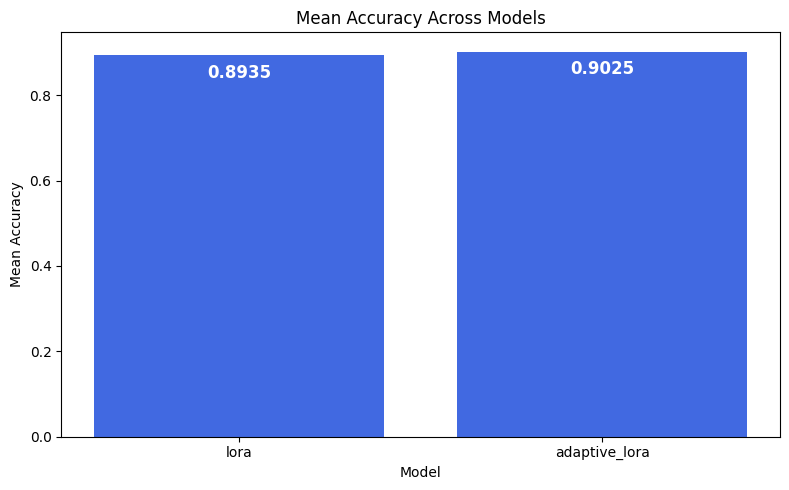

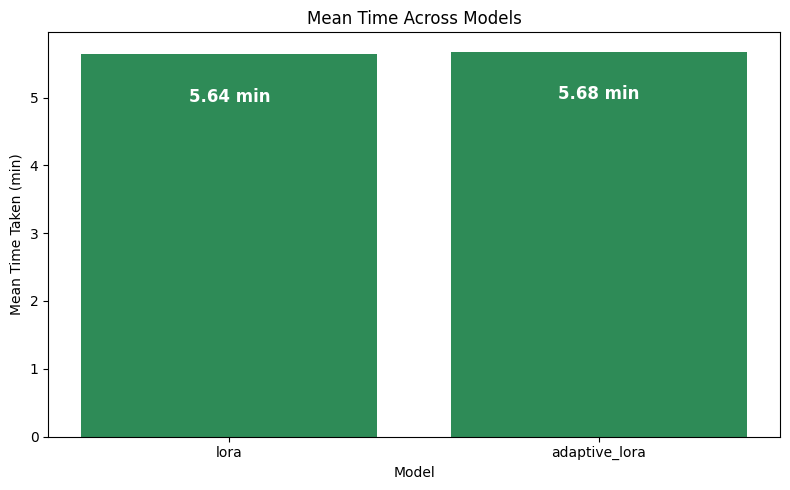

In [10]:
plot_mean_accuracy({k: v["benchmark"] for k, v in data.items()})
plot_mean_time({k: v["benchmark"] for k, v in data.items()})

In [11]:
# Load Adalora
# adalora_phase = pd.read_csv('adalora_gpu_phase_timestamps.csv')
# adalora_usage = pd.read_csv('adalora_gpu_usage_log.csv')
# adalora_phase.columns = ['run', 'phase', 'timestamp']
# adalora_usage.columns = ['timestamp', 'gpu_utilization', 'memory_usage']

# Load Adaptive LoRA
adaptive_phase = pd.read_csv('adaptive_lora_gpu_phase_timestamps.csv')
adaptive_usage = pd.read_csv('adaptive_lora_gpu_usage_log.csv')
adaptive_phase.columns = ['run', 'phase', 'timestamp']
adaptive_usage.columns = ['timestamp', 'gpu_utilization', 'memory_usage']

# Load PEFT LoRA
peft_phase = pd.read_csv('lora_gpu_phase_timestamps.csv')
peft_usage = pd.read_csv('lora_gpu_usage_log.csv')
peft_phase.columns = ['run', 'phase', 'timestamp']
peft_usage.columns = ['timestamp', 'gpu_utilization', 'memory_usage']

In [12]:
def assign_runs(usage_df, phase_df):
    usage_df['run'] = -1
    run_boundaries = {}
    for run_id in phase_df['run'].unique():
        run_data = phase_df[phase_df['run'] == run_id]
        start_time = run_data['timestamp'].min()
        end_time = run_data['timestamp'].max()
        run_boundaries[run_id] = (start_time, end_time)
    for run_id, (start, end) in run_boundaries.items():
        mask = (usage_df['timestamp'] >= start) & (usage_df['timestamp'] <= end)
        usage_df.loc[mask, 'run'] = run_id
    return usage_df

# adalora_usage = assign_runs(adalora_usage, adalora_phase)
adaptive_usage = assign_runs(adaptive_usage, adaptive_phase)
peft_usage = assign_runs(peft_usage, peft_phase)

In [13]:
# def plot_combined_gpu_utilization(adalora_usage, adaptive_usage, peft_usage):
def plot_combined_gpu_utilization(adaptive_usage, peft_usage):
    fig, ax = plt.subplots(figsize=(16, 8))

    # x_adalora = adalora_usage['timestamp'] - adalora_usage['timestamp'].min()
    x_adaptive = adaptive_usage['timestamp'] - adaptive_usage['timestamp'].min()
    x_peft = peft_usage['timestamp'] - peft_usage['timestamp'].min()

    # ax.plot(x_adalora, adalora_usage['gpu_utilization'], color='blue', label='Adalora (Standard) GPU Utilization')
    ax.plot(x_adaptive, adaptive_usage['gpu_utilization'], color='green', label='Adaptive LoRA (Novel) GPU Utilization')
    ax.plot(x_peft, peft_usage['gpu_utilization'], color='orange', label='LoRA (Standard) GPU Utilization')

    ax.set_xlabel('Relative Timestep')
    ax.set_ylabel('GPU Utilization (%)')
    ax.set_title('GPU Utilization Comparison Across Models')
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig("plots/comparison_of_gpu_utilization.png")
    plt.show()

# def plot_combined_memory_usage(adalora_usage, adaptive_usage, peft_usage):
def plot_combined_memory_usage(adaptive_usage, peft_usage):
    fig, ax = plt.subplots(figsize=(16, 8))

    # x_adalora = adalora_usage['timestamp'] - adalora_usage['timestamp'].min()
    x_adaptive = adaptive_usage['timestamp'] - adaptive_usage['timestamp'].min()
    x_peft = peft_usage['timestamp'] - peft_usage['timestamp'].min()

    ax.plot(x_peft, peft_usage['memory_usage'], color='orange', label='LoRA (Standard) Memory Usage')
    # ax.plot(x_adalora, adalora_usage['memory_usage'], color='blue', label='Adalora (Standard) Memory Usage')
    ax.plot(x_adaptive, adaptive_usage['memory_usage'], color='green', label='Adaptive LoRA (Novel) Memory Usage')

    ax.set_xlabel('Relative Timestep')
    ax.set_ylabel('Memory Usage (MB)')
    ax.set_title('Memory Usage Comparison Across Models')
    # ax.set_ylim(0, max(adalora_usage['memory_usage'].max(), adaptive_usage['memory_usage'].max(), peft_usage['memory_usage'].max()) * 1.1)
    ax.set_ylim(0, max(adaptive_usage['memory_usage'].max(), peft_usage['memory_usage'].max()) * 1.1)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig("plots/comparison_of_memory_utilization.png")
    plt.show()

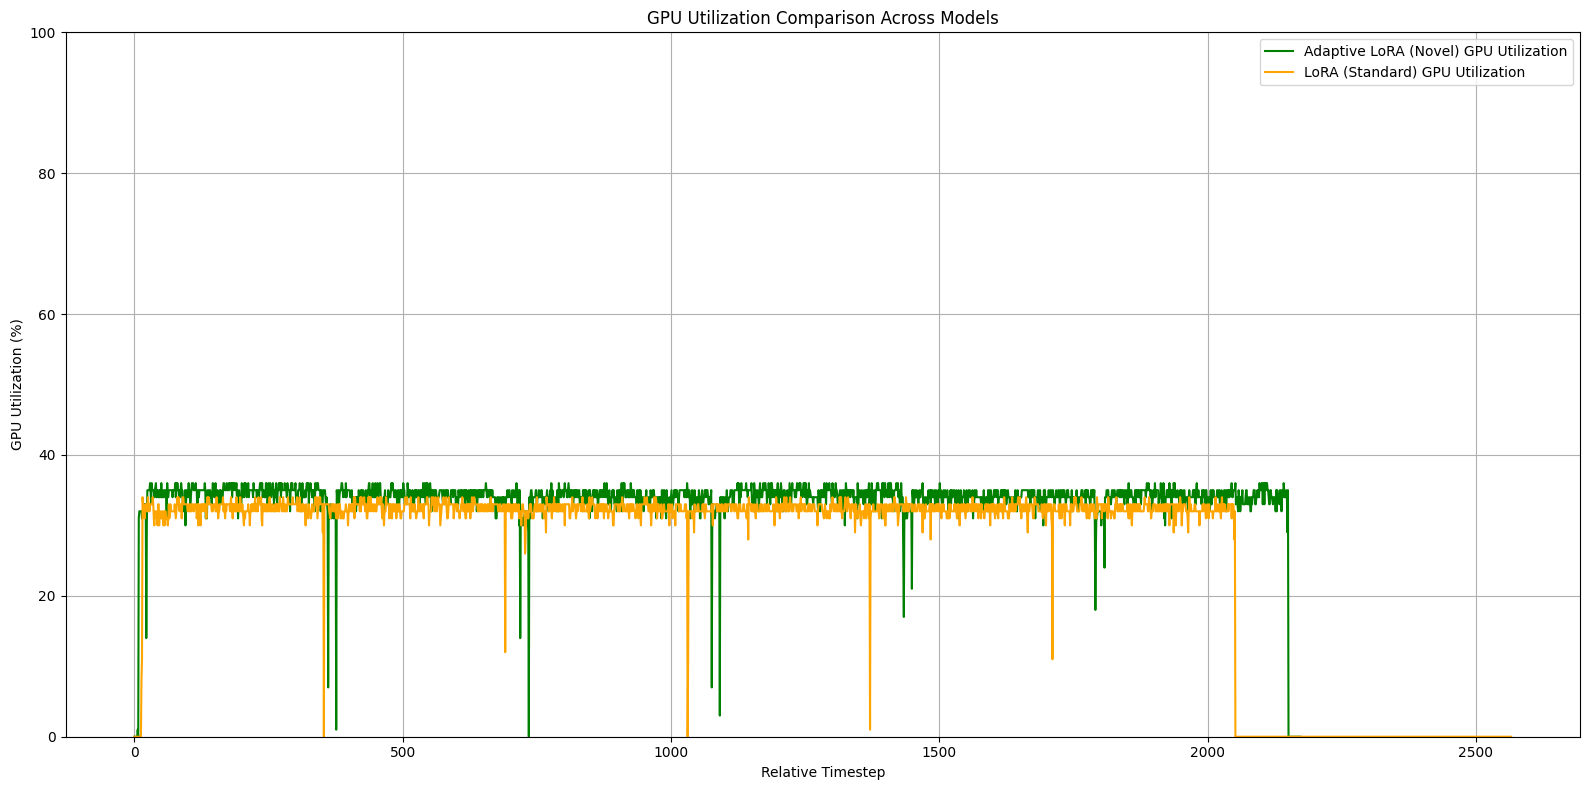

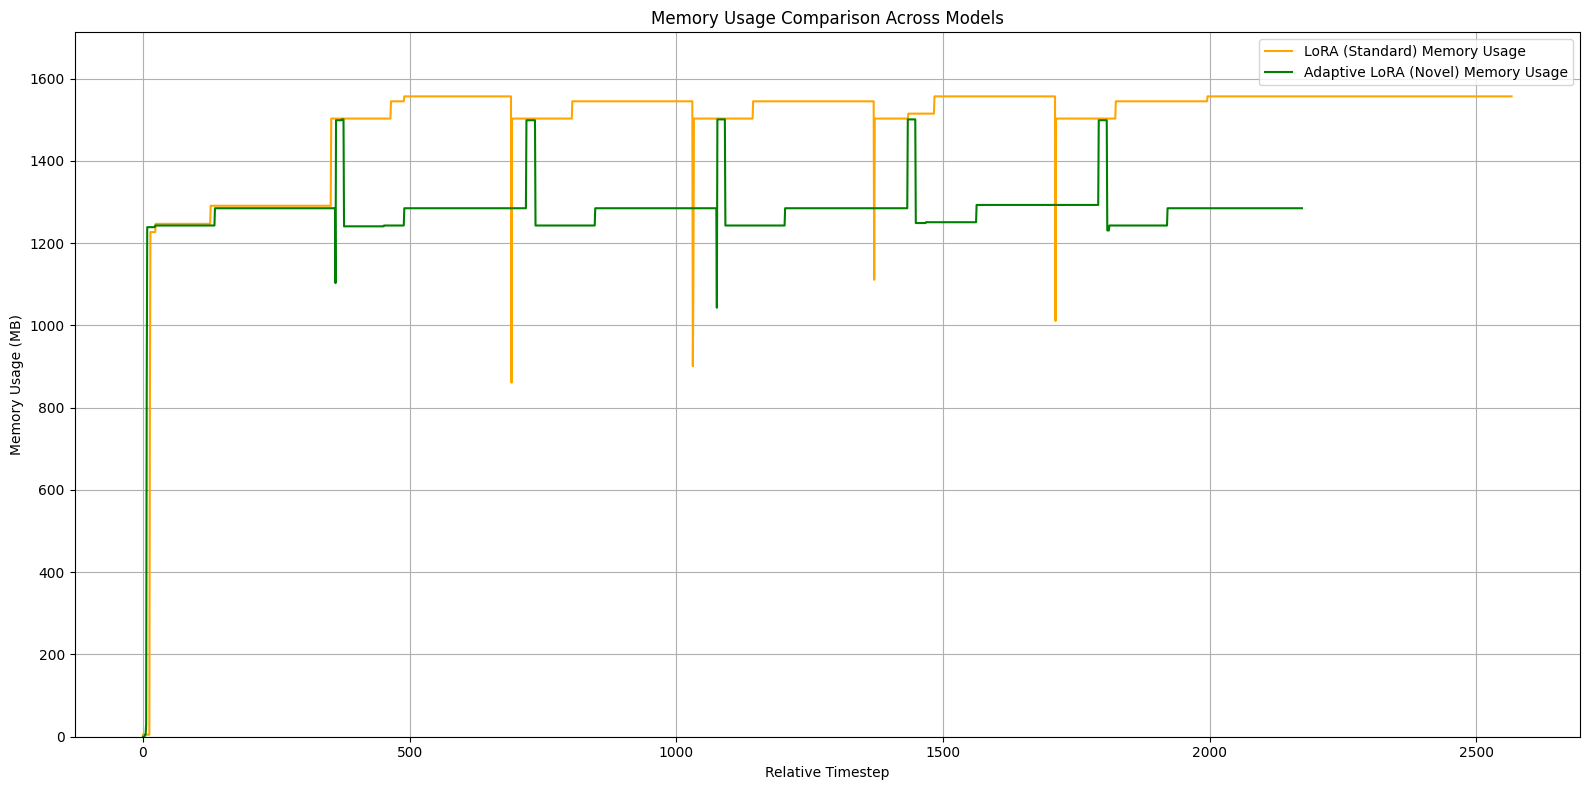

In [14]:
# plot_combined_gpu_utilization(adalora_usage, adaptive_usage, peft_usage)
# plot_combined_memory_usage(adalora_usage, adaptive_usage, peft_usage)
plot_combined_gpu_utilization(adaptive_usage, peft_usage)
plot_combined_memory_usage(adaptive_usage, peft_usage)

In [15]:
# Color scheme matching the model colors
model_colors = {
    # "adalora": "blue",
    "adaptive_lora": "green",
    "lora": "orange"
}

def plot_accuracy_per_run(benchmark_df, model_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    # runs = benchmark_df["run"]
    runs = benchmark_df["Run ID"]
    # accuracies = benchmark_df["accuracy"]
    accuracies = benchmark_df["Final Accuracy"]
    mean_acc = accuracies.mean()

    bars = plt.bar(runs, accuracies, color=model_colors[model_name])

    # Plot mean line
    plt.axhline(mean_acc, linestyle="--", color="red", label=f"Mean {mean_acc:.4f}")

    # Annotate values
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval - 0.02,
            f"{yval:.4f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Run ID")
    plt.ylabel("Accuracy")
    plt.ylim(0,1.05)
    plt.title(f"Accuracy per Run - {model_name.capitalize()}")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_accuracy_per_run.png")
    plt.show()

def plot_time_per_run(benchmark_df, model_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    # runs = benchmark_df["run"]
    # times = benchmark_df["time"]
    runs = benchmark_df["Run ID"]
    if "adaptive" in model_name:
      times = benchmark_df["Total Time (min)"]
    else:
      times = benchmark_df["Training Time (min)"]
    mean_time = times.mean()

    bars = plt.bar(runs, times, color=model_colors[model_name])

    # Plot mean line
    plt.axhline(mean_time, linestyle="--", color="red", label=f"Mean {mean_time:.2f} min")

    # Annotate values
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval - 0.5,
            f"{yval:.2f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Run ID")
    plt.ylabel("Time Taken (min)")
    plt.ylim(0,8)
    plt.title(f"Time Taken per Run - {model_name.capitalize()}")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_training_time_per_run.png")
    plt.show()


In [16]:
for model, d in data.items():
    print(model, d)

lora {'phase':     0  training_start  1746916114.8628464
0   0    training_end        1.746916e+09
1   1  training_start        1.746916e+09
2   1    training_end        1.746917e+09
3   2  training_start        1.746917e+09
4   2    training_end        1.746917e+09
5   3  training_start        1.746917e+09
6   3    training_end        1.746917e+09
7   4  training_start        1.746917e+09
8   4    training_end        1.746918e+09
9   5  training_start        1.746918e+09
10  5    training_end        1.746918e+09, 'usage':        timestamp  gpu_util_percent  memory_used_MB
0     1746916102                 0               5
1     1746916103                 0               5
2     1746916104                 0               5
3     1746916105                 0               5
4     1746916106                 0               5
...          ...               ...             ...
2515  1746918664                 0            1557
2516  1746918665                 0            1557
2517  174691

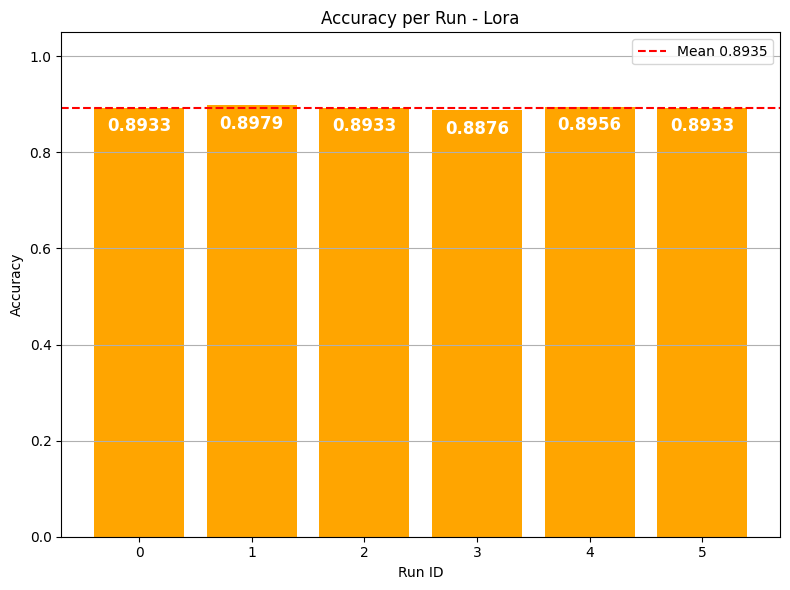

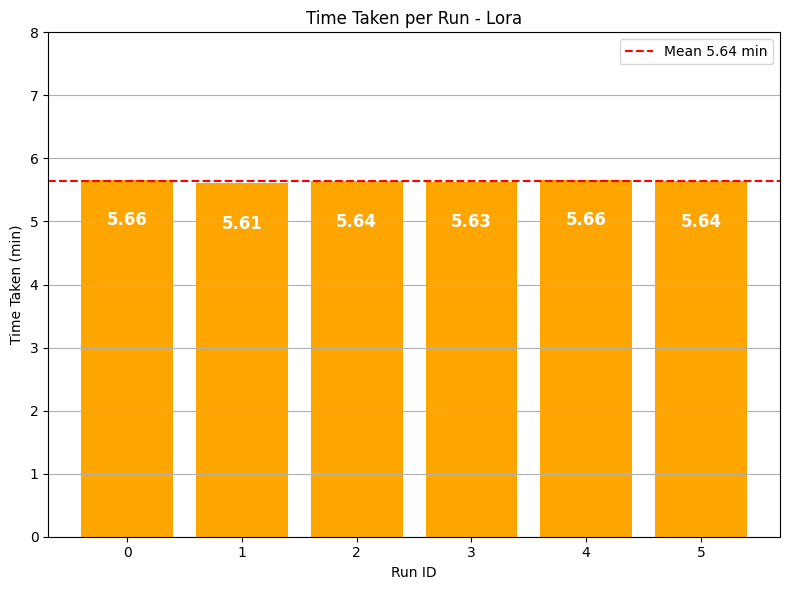

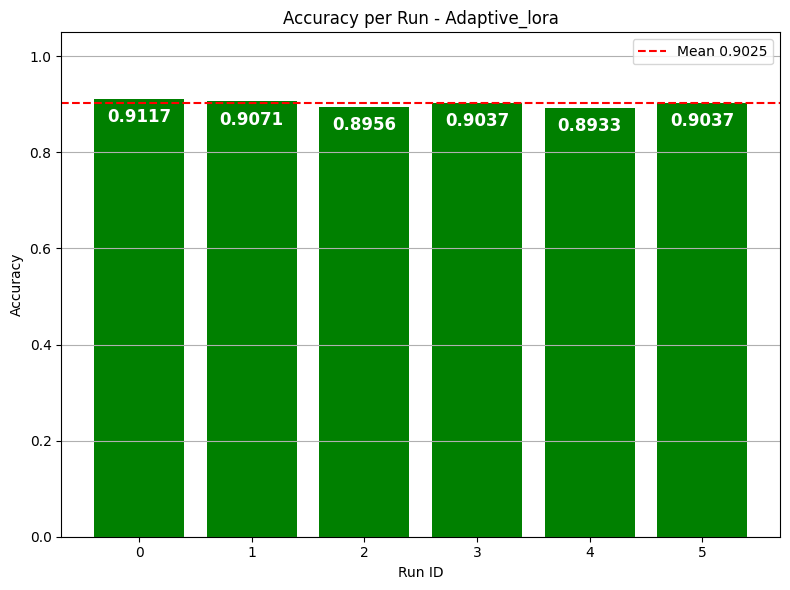

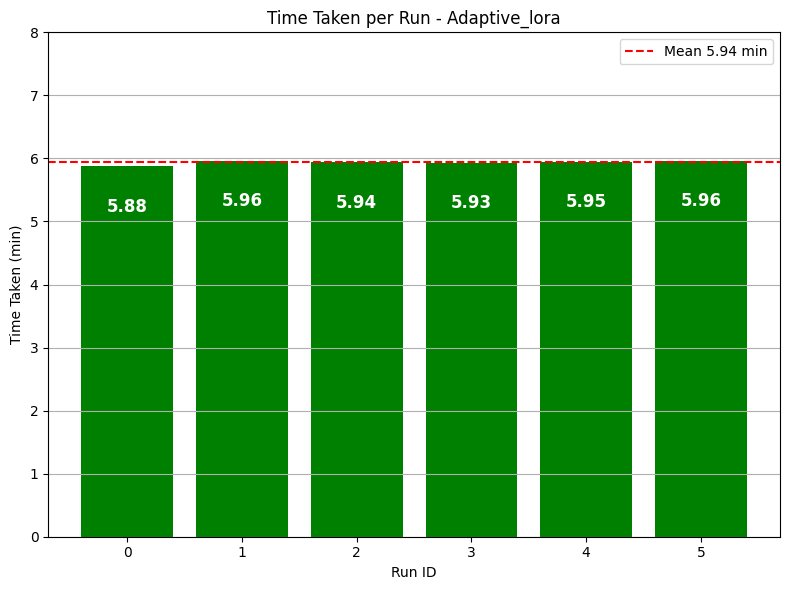

In [17]:
for model, d in data.items():
    # print(model, d)
    plot_accuracy_per_run(d["benchmark"], model)
    plot_time_per_run(d["benchmark"], model)


In [18]:
for model, d in data.items():
    print(model, d)

lora {'phase':     0  training_start  1746916114.8628464
0   0    training_end        1.746916e+09
1   1  training_start        1.746916e+09
2   1    training_end        1.746917e+09
3   2  training_start        1.746917e+09
4   2    training_end        1.746917e+09
5   3  training_start        1.746917e+09
6   3    training_end        1.746917e+09
7   4  training_start        1.746917e+09
8   4    training_end        1.746918e+09
9   5  training_start        1.746918e+09
10  5    training_end        1.746918e+09, 'usage':        timestamp  gpu_util_percent  memory_used_MB
0     1746916102                 0               5
1     1746916103                 0               5
2     1746916104                 0               5
3     1746916105                 0               5
4     1746916106                 0               5
...          ...               ...             ...
2515  1746918664                 0            1557
2516  1746918665                 0            1557
2517  174691

In [24]:
for model, d in data.items():
  print(f"""{model}_max_memory_usage: {max(d['usage']['memory_used_MB'])}""")
  print(f"""{model}_max_gpu_usage: {max(d['usage']['gpu_util_percent'])}""")
  print(f"""{model}_average_memory_usage: {sum(d['usage']['memory_used_MB'])/len(d['usage']['memory_used_MB'])}""")
  print(f"""{model}_average_gpu_usage: {sum(d['usage']['gpu_util_percent'])/len(d['usage']['gpu_util_percent'])}""")

lora_max_memory_usage: 1557
lora_max_gpu_usage: 34
lora_average_memory_usage: 1495.8325396825396
lora_average_gpu_usage: 25.623015873015873
adaptive_lora_max_memory_usage: 1501
adaptive_lora_max_gpu_usage: 36
adaptive_lora_average_memory_usage: 1275.8041237113403
adaptive_lora_average_gpu_usage: 33.563261480787254
